# 1. Setup & Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from imblearn.pipeline import Pipeline

import joblib


import numpy as np
import matplotlib.pyplot as plt

# 2.Feature Engineering Function

In [2]:
def feature_engineering(X):
    X = X.copy()
    X['diffOrig'] = X['oldbalanceOrg'] - X['newbalanceOrig']
    X['diffDest'] = X['newbalanceDest'] - X['oldbalanceDest']
    X['amt_ratio'] = X['amount'] / (X['oldbalanceOrg'] + 1)
    X['is_suspicious_type'] = X['type'].isin(['TRANSFER','CASH_OUT']).astype(int)
    return X


# 3. Load & Split Data

In [3]:
df = pd.read_csv("../Data/Cleaned/cleaned_data.csv")
df = df.drop(['nameOrig', 'nameDest'], axis=1)

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# 4. Preprocessor

In [4]:
categorical = ['type']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical + ['diffOrig','diffDest','amt_ratio','is_suspicious_type']),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)


# 5. Random Forest Pipeline

In [5]:
pipeline = Pipeline(steps=[
    ('fe', FunctionTransformer(feature_engineering)),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',  # very important for imbalance
        n_jobs=-1,
        random_state=42
    ))
])


# 6. Train & Evaluate

In [6]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('fe',
                 FunctionTransformer(func=<function feature_engineering at 0x0000021FB7D0E840>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest', 'diffOrig',
                                                   'diffDest', 'amt_ratio',
                                                   'is_suspicious_type']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [7]:

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906323
           1       0.95      0.96      0.96      2459

    accuracy                           1.00   1908782
   macro avg       0.98      0.98      0.98   1908782
weighted avg       1.00      1.00      1.00   1908782

ROC-AUC: 0.9983651975191278


## Now that’s what we call a game changer

**RandomForestClassifier results are outstanding:**

* Precision (fraud): 0.95 → when the model says "fraud", it’s right 95% of the time.

* Recall (fraud): 0.96 → it catches 96% of all frauds.

* ROC-AUC: 0.998 → almost perfect ranking ability.

Overall accuracy: basically 100% (but we don’t care much about accuracy here because of imbalance).

# 7. Feature importance

Find out which features Random Forest thinks are most important:

In [8]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importances  = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices[:15]:  # top 15 features
    print(f"{feature_names[i]}: {importances[i]:.4f}")
len(feature_names)

num__amt_ratio: 0.2655
num__diffOrig: 0.2449
num__is_suspicious_type: 0.1273
num__newbalanceOrig: 0.0868
num__oldbalanceOrg: 0.0680
num__amount: 0.0448
num__diffDest: 0.0388
cat__type_TRANSFER: 0.0385
cat__type_PAYMENT: 0.0266
num__step: 0.0193
num__newbalanceDest: 0.0156
cat__type_CASH_OUT: 0.0146
num__oldbalanceDest: 0.0092
cat__type_DEBIT: 0.0000


14

* Plot the top 15 features in a bar chart.

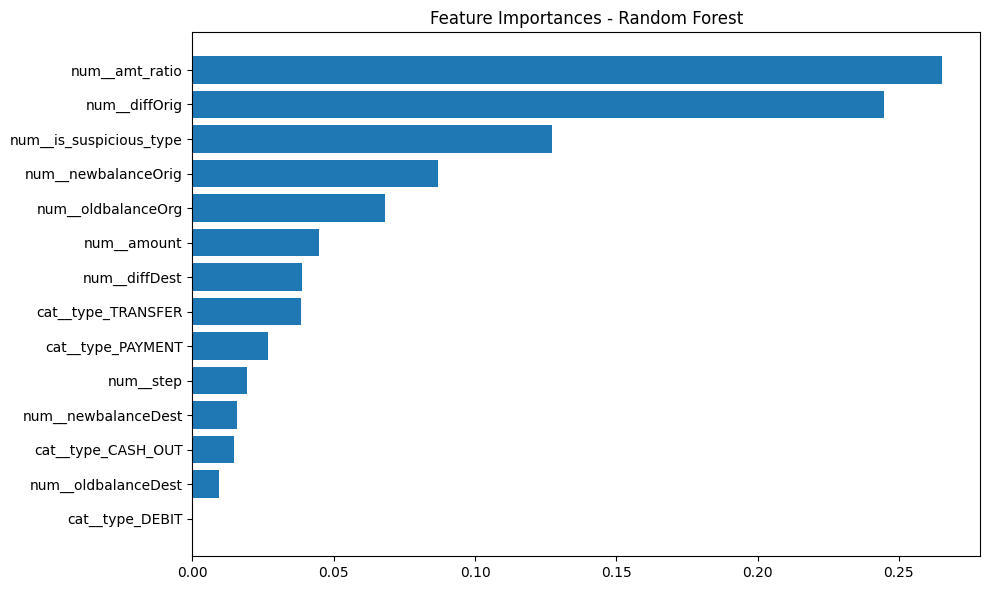

In [9]:
plt.figure(figsize=(10,6))
plt.title("Feature Importances - Random Forest")
plt.barh(range(14), importances[indices][:14], align='center')
plt.yticks(range(14), [feature_names[i] for i in indices[:14]])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

- **Engineered features matter**:
    - `amt_ratio`, `diffOrig`, `is_suspicious_type` are far more important than raw balances or transaction step.
- **Type encoding helps, but not all types**:
    - `TRANSFER` and `PAYMENT` matter, `DEBIT` does not.
- **Random Forest is effectively using domain knowledge** you encoded in features.
- fraud is strongly driven by transaction size relative to balance, suspicious transaction types, and balance inconsistencies.

# Dumb trained pipeline

In [12]:

joblib.dump(pipeline,'../App/fraud_detection_model.pkl')

['../App/fraud_detection_model.pkl']